In [1]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from itertools import product, combinations
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

import chainer
import chainer.functions as F
import chainer.links as L
import chainer.initializers as I

from ipywidgets import widgets
from ipywidgets.widgets import *
from IPython.display import display

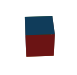

In [2]:
points = np.array([[-1, -1, -1],
                      [1, -1, -1 ],
                      [1, 1, -1],
                      [-1, 1, -1],
                      [-1, -1, 1],
                      [1, -1, 1 ],
                      [1, 1, 1],
                      [-1, 1, 1]])

fig = plt.figure(figsize=(1,1))
canvas = FigureCanvas(fig)
ax = fig.add_subplot(111, projection='3d')
r = [-1,1]
X, Y = np.meshgrid(r, r)
ax.plot_surface(X,Y,1)
ax.plot_surface(X,Y,-1)
ax.plot_surface(X,-1,Y)
ax.plot_surface(X,1,Y)
ax.plot_surface(1,X,Y)
ax.plot_surface(-1,X,Y)
plt.axis('off')
def get_yaw(i):
    return i * np.pi / 2 / 30
def get_pitch(i): return i * np.pi / 4 / 30
yaw_angles = get_yaw(np.arange(30))
pitch_angles = get_pitch(np.arange(30))
yaw_mat, pitch_mat = np.meshgrid(yaw_angles, pitch_angles)
images = []
for pitch in pitch_angles:
    for yaw in yaw_angles:
        ax.view_init(pitch * 180 / np.pi, yaw * 180 / np.pi)
        canvas.draw()
        rawimage = np.fromstring(canvas.tostring_rgb(), dtype='uint8')
        image = rawimage.reshape((int(np.sqrt(len(rawimage) // 3)), -1, 3))
        cropimage = image[12:-12, 12:-12, :]
        rawcropimage = np.array(cropimage.flat)
        images.append(rawcropimage)

In [3]:
print(np.array(images).max())

255


(6912,)
(48, 48, 3)


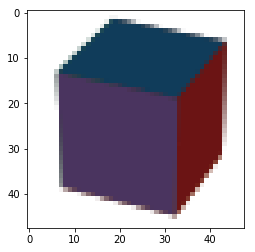

In [4]:
def plotimg(yaw,pitch):
    print(images[yaw + pitch * len(yaw_angles)].shape)
    image = images[yaw + pitch * len(yaw_angles)]
    img = image.reshape((int(np.sqrt(len(image) // 3)), -1, 3))
    print(img.shape)
    plt.imshow(img)
    k = np.arange(50)

interact(plotimg, yaw=(0,len(yaw_angles)-1,1), pitch=(0,len(pitch_angles)-1,1));

In [5]:
class Regressor(chainer.Chain):
    def __init__(self, outputs=1, n_units=128):
        super(Regressor, self).__init__(
            l1 = L.Linear(None, n_units),
            l2 = L.Linear(n_units, outputs)
        )

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = self.l2(h1)
        return h2

In [6]:
class Regressor2(chainer.Chain):
    def __init__(self, outputs=1, n_units=128):
        super(Regressor2, self).__init__(
            l1 = L.Linear(None, n_units),
            l2 = L.Linear(n_units, n_units),
            l3 = L.Linear(n_units, outputs)
        )

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return F.sigmoid(self.l3(h2)) * 255

In [7]:
class CNNRegressor2(chainer.Chain):
    def __init__(self, outputs=1, n_units=128):
        super(CNNRegressor2, self).__init__(
            conv1 = L.Convolution2D(None, n_units, ksize=3),
            l2 = L.Linear(n_units, n_units),
            l3 = L.Linear(n_units, outputs)
        )

    def __call__(self, x):
        h1 = self.conv1(x)
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

In [8]:
def run_train(trainx, trainy, epoch=10000, report_period=100, report_period_seconds=0, regularize=0.0001,
              model=None, optimizer=None):
    from time import clock
    start = clock()
    last_report = start

    if model == None:
        model = Regressor2(trainy.shape[1], 512)
        model.zerograds()

    if optimizer == None:
        optimizer = chainer.optimizers.Adam()
        optimizer.setup(model)
        optimizer.add_hook(chainer.optimizer.WeightDecay(regularize))
    loss_hist = []

    for i in range(epoch):
        loss = F.mean_squared_error(model(trainx), trainy)
        loss_hist.append(loss.data)
        if i % report_period == 0:
            if last_report + report_period_seconds < clock():
                ups = i / (clock() - start)
                eta = (epoch - i) / ups if ups != 0 else 0
                etas = '%d:%05.2f' % (eta // 60, eta % 60) if 60 < eta else '%.2f' % eta
                print(i, 'loss', loss.data, ', ups: %.2f' % ups, ', eta: ' + etas)
                last_report = clock()
        #optimizer.weight_decay(0.005)
        optimizer.update(lambda x,y: F.mean_squared_error(model(x), y), trainx, trainy)

    return model, loss_hist, optimizer

In [9]:
use_flat = False
if use_flat:
    x = y = range(int(np.sqrt(len(images[0]) // 3)))
    print(len(x))
    A, X, Y = np.meshgrid(angles, x, y)
    print(X.shape, Y.shape, A.shape[0] * A.shape[1] * A.shape[2])
    fXY = np.vstack([A.flat, np.array(X.flat), np.array(Y.flat)])
    trainx = np.array(fXY, dtype=np.float32).T / max(angles)
    print(fXY[1:,:].shape, 'image: ', images[0].shape)
    imageXY = np.zeros((trainx.shape[0],3))
    i = 0
    for image in images:
        imageXY[i:(i+image.shape[0]//3),:] = image.reshape((-1,3))
        i += image.shape[0]//3
    trainy = np.array(imageXY, dtype=np.float32)
else:
    trainx = np.vstack([yaw_mat.flat, pitch_mat.flat]).astype(np.float32).T
    trainy = np.array(images, dtype=np.float32)
print(trainx.shape, trainy.shape)


(900, 2) (900, 6912)


In [10]:
model, loss_hist, optimizer = run_train(trainx, trainy, epoch=1000, report_period=10, report_period_seconds=5, regularize=0.00001)

10 loss 2823.37841796875 , ups: 1.70 , eta: 9:40.69
20 loss 2206.581298828125 , ups: 1.64 , eta: 9:58.90
30 loss 1883.0850830078125 , ups: 1.63 , eta: 9:56.77
40 loss 1665.369873046875 , ups: 1.62 , eta: 9:51.49
50 loss 1515.438720703125 , ups: 1.62 , eta: 9:46.47
60 loss 1400.591552734375 , ups: 1.62 , eta: 9:39.09
70 loss 1294.40869140625 , ups: 1.62 , eta: 9:32.47
80 loss 1177.2098388671875 , ups: 1.63 , eta: 9:25.84
90 loss 1054.0372314453125 , ups: 1.62 , eta: 9:20.13
100 loss 945.4100952148438 , ups: 1.62 , eta: 9:13.85
110 loss 855.0663452148438 , ups: 1.63 , eta: 9:07.35
120 loss 776.1846923828125 , ups: 1.63 , eta: 9:01.37
130 loss 705.9933471679688 , ups: 1.63 , eta: 8:55.06
140 loss 646.392333984375 , ups: 1.63 , eta: 8:48.75
150 loss 595.8480834960938 , ups: 1.62 , eta: 8:43.30
160 loss 554.7085571289062 , ups: 1.63 , eta: 8:36.60
170 loss 520.92236328125 , ups: 1.63 , eta: 8:30.21
180 loss 492.98089599609375 , ups: 1.63 , eta: 8:24.01
190 loss 469.03204345703125 , ups: 1.6

In [15]:
chainer.serializers.save_npz("result/image3d2.model", model)

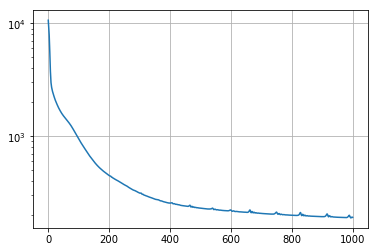

In [11]:
plt.semilogy(loss_hist)
plt.grid()

(1, 6912) 5.31971e-05 255.0


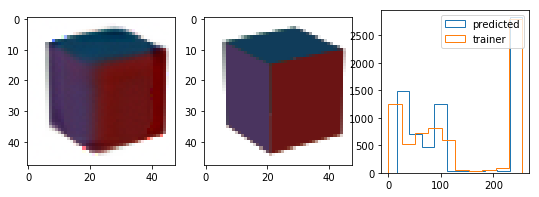

In [17]:
def plotimg(yaw,pitch):
    predicted = model(np.array([get_yaw(yaw), get_pitch(pitch)], dtype=np.float32)[np.newaxis]).data
    print(predicted.shape, predicted.min(), predicted.max())
    xs = int(np.sqrt(predicted.shape[1] // 3))
    img = predicted.reshape((xs, -1, 3))
    fig, ax = plt.subplots(1, 3, figsize=(9,3))
    ax[0].imshow(img / 255)
    if 0 <= yaw and yaw < len(yaw_angles) and 0 <= pitch and pitch < len(pitch_angles):
        image = images[yaw + pitch * len(yaw_angles)]
        img2 = image.reshape((int(np.sqrt(len(image) // 3)), -1, 3))
        ax[1].imshow(img2)
        ax[2].hist(img2.flat, histtype='step')
    ax[2].hist(predicted.flat, histtype='step')
    ax[2].legend(['predicted', 'trainer'])

interact(plotimg, yaw=(-10,len(yaw_angles)+10,1), pitch=(-10,len(pitch_angles)+10,1));

[[  0.           0.           0.52631581]
 [  1.           0.           0.52631581]
 [  2.           0.           0.52631581]
 ..., 
 [ 21.          23.           0.52631581]
 [ 22.          23.           0.52631581]
 [ 23.          23.           0.52631581]]
(576, 3) 24 8
(24, 24, 3)


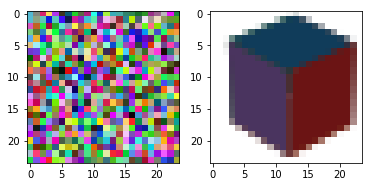

In [249]:
def plotimg(iangle):
    X, Y = np.meshgrid(x,y)
    XYA = np.vstack([np.array(X.flat), np.array(Y.flat),
                    np.ones(X.shape[0] * X.shape[1]) * angles[iangle] / max(angles)]).astype(np.float32).T
    predicted = model(XYA).data
    xs = int(np.sqrt(len(images[0]) // 3))
    print(predicted.shape, xs, predicted.shape[0] // (3 * xs))
    img = predicted.reshape((xs, -1, 3))
    print(img.shape)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(img)
    image = images[iangle]
    img = image.reshape((int(np.sqrt(len(image) // 3)), -1, 3))
    ax[1].imshow(img)

interact(plotimg, iangle=(0,len(angles)-1,1));